In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datascience
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px

%matplotlib inline


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
forestfires_df = pd.read_csv("forestfires.csv")
forestfires_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9

- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9

- month - month of the year: 'jan' to 'dec'

- day - day of the week: 'mon' to 'sun'

- FFMC - FFMC index from the FWI system: 18.7 to 96.20

- DMC - DMC index from the FWI system: 1.1 to 291.3

- DC - DC index from the FWI system: 7.9 to 860.6

- ISI - ISI index from the FWI system: 0.0 to 56.10

- temp - temperature in Celsius degrees: 2.2 to 33.30

- RH - relative humidity in %: 15.0 to 100

- wind - wind speed in km/h: 0.40 to 9.40

- rain - outside rain in mm/m2 : 0.0 to 6.4

- area - the burned area of the forest (in ha): 0.00 to 1090.84

- (this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

In [ ]:
# In the Non-Null Count we can see that we have no missing values as there are already 517 entries total for each variable.
forestfires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [ ]:
forestfires_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# EDA: Data cleaning

## Helper Functions

In [ ]:
def get_season(month):
    if month in ['dec', 'jan', 'feb']:
        return 'winter'
    elif month in ['mar', 'apr', 'may']:
        return 'spring'
    elif month in ['jun', 'jul', 'aug']:
        return 'summer'
    else:
        return 'fall'

def get_risk(area):
    if area > 10:
        return 1
    else:
        return 0

In [ ]:
mean = forestfires_df['area'].mean()
std = forestfires_df['area'].std()
mean, std

(12.847292069632493, 63.65581846794089)

## Count and Distribution Plots of categorical variables (days, months, and seasons)

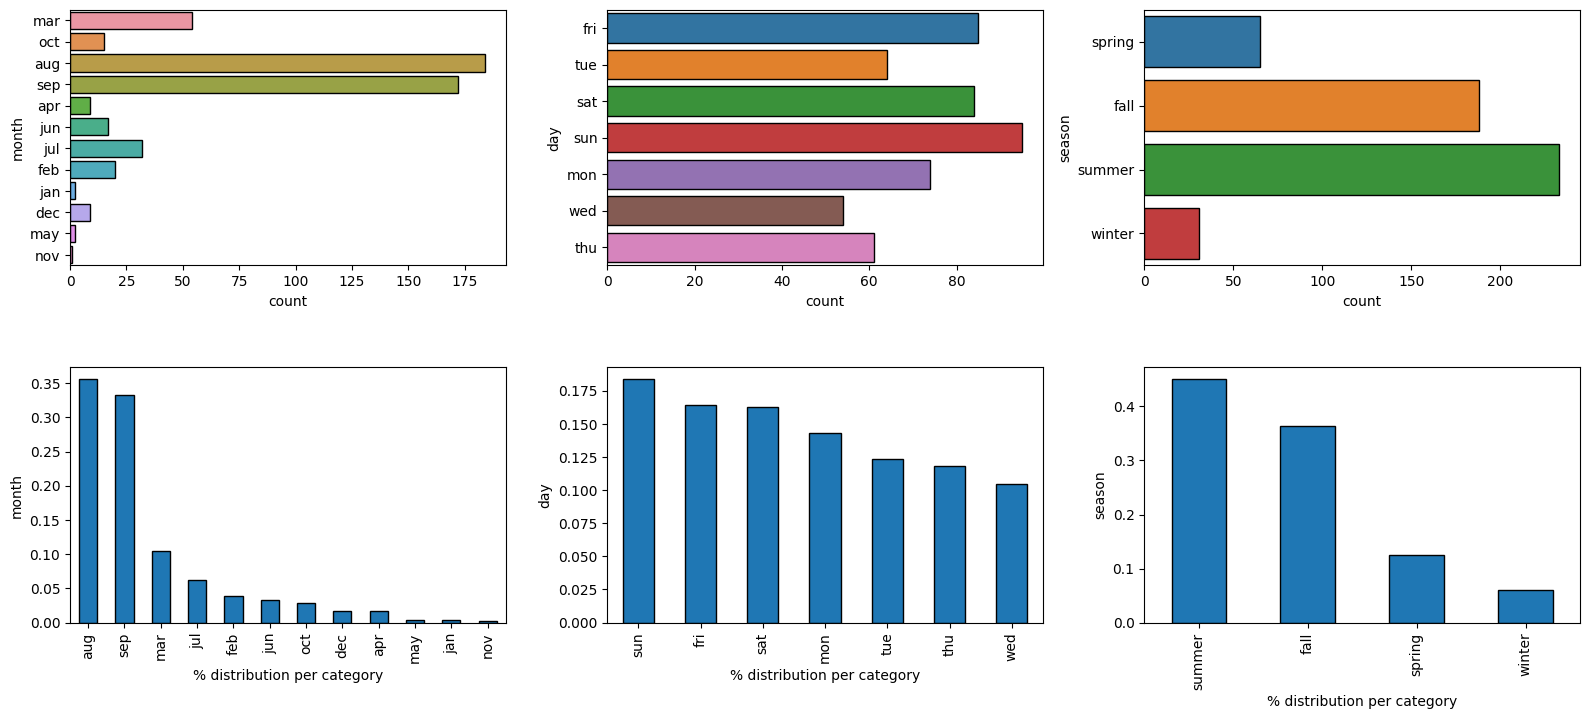

In [ ]:
cat_dict = {'month': forestfires_df['month'],
           'day': forestfires_df['day'],
           'season': forestfires_df['month'].apply(get_season)}
cat_df = pd.DataFrame(cat_dict)
cat_columns = ['month', 'day', 'season']

# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(3,3,i)
    sns.countplot(data=cat_df,y=col)
    plt.subplot(3,3,i+3)
    cat_df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  


## Visualizing Percentiles

- get a better sense of what we would consider a moderate/high-risk burned area

25th percentile: 0.0
50th percentile: 0.52
75th percentile: 6.57
90th percentile: 25.262000000000043
95th percentile: 48.713999999999984


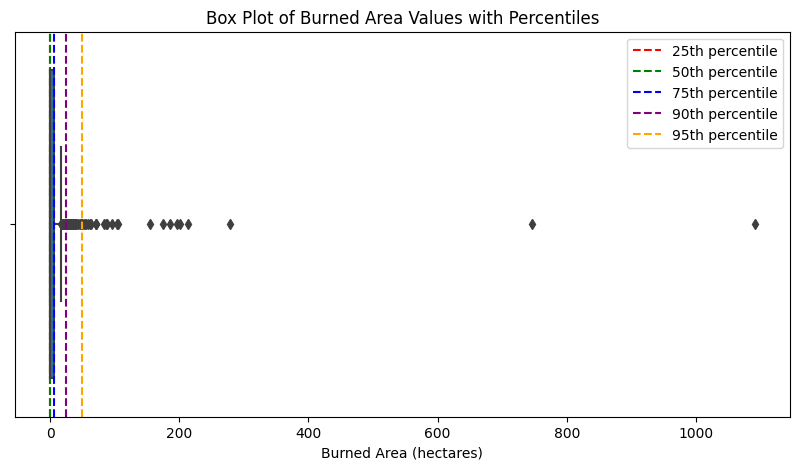

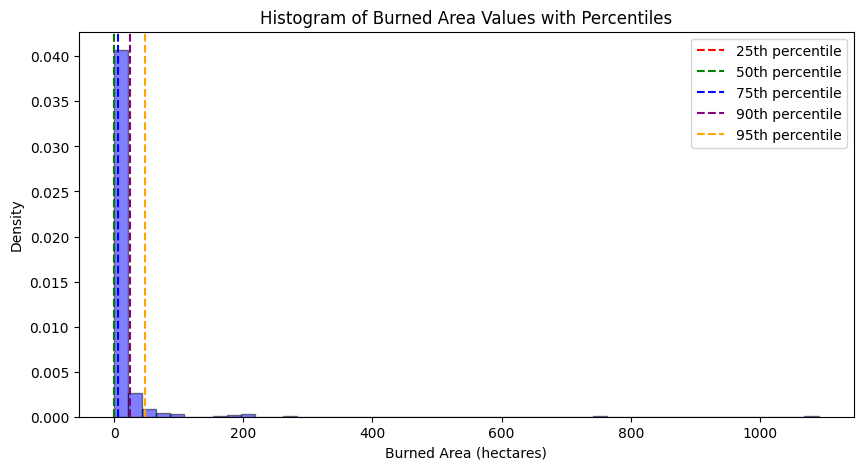

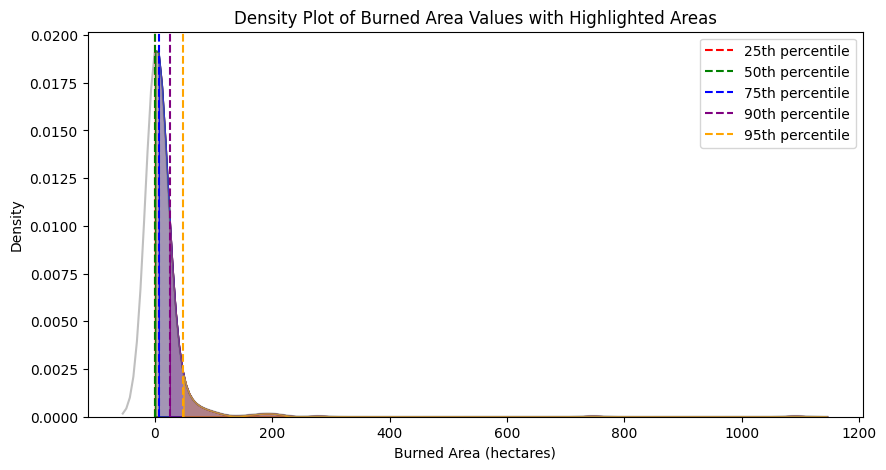

In [ ]:
burned_area = forestfires_df['area']

percentiles = [25, 50, 75, 90, 95]
percentile_values = np.percentile(burned_area, percentiles)

# Display percentile values
for i, p in enumerate(percentiles):
    print(f"{p}th percentile: {percentile_values[i]}")

colors = ['red', 'green', 'blue', 'purple', 'orange']

# Create a box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=burned_area)
for p, value, color in zip(percentiles, percentile_values, colors):
    plt.axvline(value, color=color, linestyle='--', label=f'{p}th percentile')
plt.xlabel('Burned Area (hectares)')
plt.legend()
plt.title('Box Plot of Burned Area Values with Percentiles')
plt.show()

# Create a custom percentile plot
plt.figure(figsize=(10, 5))
plt.hist(burned_area, bins=50, color='blue', edgecolor='black', alpha=0.5, density=True)
for p, value, color in zip(percentiles, percentile_values, colors):
    plt.axvline(value, color=color, linestyle='--', label=f'{p}th percentile')
plt.xlabel('Burned Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Burned Area Values with Percentiles')
plt.show()

# Create a custom density plot with colored dashed lines and highlighted areas
plt.figure(figsize=(10, 5))
sns.kdeplot(burned_area, fill=False, color='gray', alpha=0.5)

for p, value, color in zip(percentiles, percentile_values, colors):
    plt.axvline(value, color=color, linestyle='--', label=f'{p}th percentile')
    sns.kdeplot(burned_area, fill=True, clip=(value, np.inf), color=color, alpha=0.2)

plt.xlabel('Burned Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.title('Density Plot of Burned Area Values with Highlighted Areas')
plt.show()

## Visualizing 10 hectares of burned area (moderate/high risk) in our dataset and finding its percentile

The value 10 is at the 81.92th percentile.


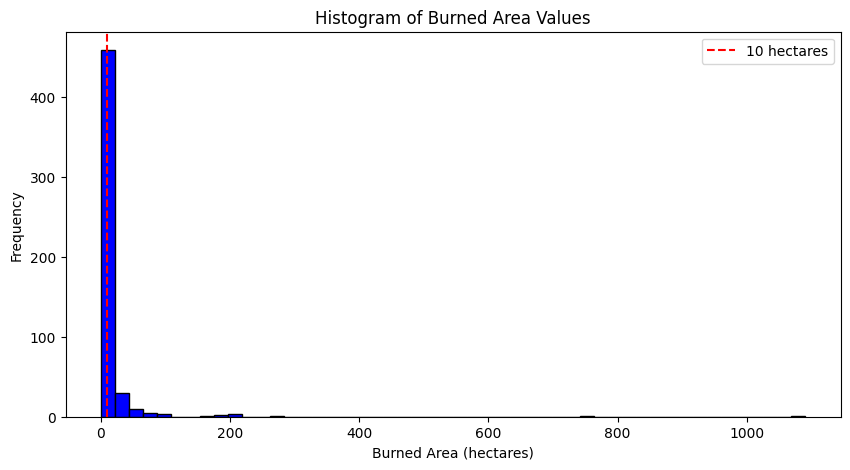

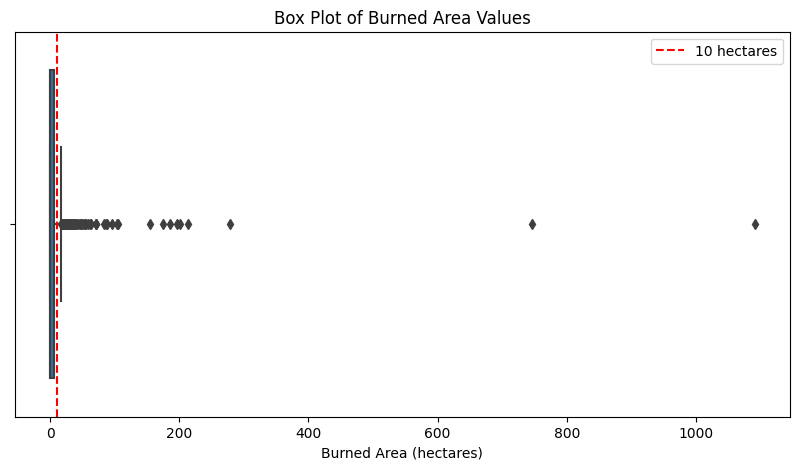

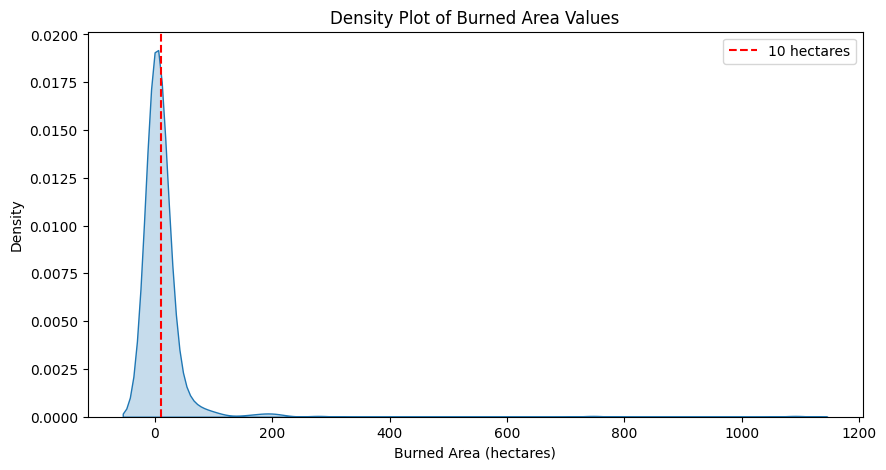

In [ ]:
# Calculate the percentiles for 0 to 100
percentiles = np.arange(0, 101)
percentile_values = np.percentile(burned_area, percentiles)

# Find the percentile for the value 10 using interpolation
value = 10
percentile_10 = np.interp(value, percentile_values, percentiles)
print(f"The value 10 is at the {percentile_10:.2f}th percentile.")

# Create a histogram
plt.figure(figsize=(10, 5))
plt.hist(burned_area, bins=50, color='blue', edgecolor='black')
plt.axvline(10, color='red', linestyle='--', label='10 hectares')
plt.xlabel('Burned Area (hectares)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Burned Area Values')
plt.show()

# Create a box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=burned_area)
plt.axvline(10, color='red', linestyle='--', label='10 hectares')
plt.xlabel('Burned Area (hectares)')
plt.legend()
plt.title('Box Plot of Burned Area Values')
plt.show()

# Create a density plot
plt.figure(figsize=(10, 5))
sns.kdeplot(burned_area, fill=True)
plt.axvline(10, color='red', linestyle='--', label='10 hectares')
plt.xlabel('Burned Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.title('Density Plot of Burned Area Values')
plt.show()

- A high number of forest fires occur in the month of August and September.

- The days Friday to Monday have a higher proportion of cases (no strong indicators).

## Categorical Variable Conversion

## Heatmaps

In [ ]:
forestfires_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [ ]:
forestfires_df['high risk']  = forestfires_df['area'].apply(get_risk)
forestfires_df['season'] = forestfires_df['month'].apply(get_season)

# Calculate the correlation matrix
subdf = forestfires_df[['high risk', 'area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'day', 'month', 'season']]
corr_matrix = subdf.corr()

In [ ]:
import plotly.subplots as sp

# Create a subplot with heatmap
fig = sp.make_subplots(rows=1, cols=1)
heatmap = go.Heatmap(z=corr_matrix, x=corr_matrix.columns, y=corr_matrix.columns, colorscale='RdBu_r', zmin=-1, zmax=1)
fig.add_trace(heatmap)

# Add annotations for the correlation values
for i, row in enumerate(corr_matrix.index):
    for j, col in enumerate(corr_matrix.columns):
        fig.add_annotation(go.layout.Annotation(text=f"{corr_matrix.iloc[i, j]:.2f}", x=col, y=row, showarrow=False, font=dict(size=12)))

# Customize the plot layout
fig.update_layout(title='Correlation Matrix Heatmap', xaxis_title='Variables', yaxis_title='Variables')

# Show the plot
fig.show()

In [ ]:
subdf.corr()['high risk'].sort_values(ascending=False)

high risk    1.000000
area         0.374235
wind         0.076253
rain         0.073343
DC           0.041188
DMC          0.036095
FFMC         0.014812
temp         0.013714
ISI         -0.018922
RH          -0.040864
Name: high risk, dtype: float64

## Distributions

In [ ]:
# Low correlation scores suggests that there may not be strong linear relationships between the variables.
# Use scatterplot to see other relationship
subdf_scatter = forestfires_df[['high risk', 'area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]

custom_colors = {'0': 'turquoise', '1': 'orangered'}


fig = px.scatter_matrix(subdf_scatter, 
                        color='high risk', 
                        dimensions=['area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], 
                        title='Scatter Plot Matrix of Features', 
                        opacity=0.5,
                        hover_name=['high risk' if hr == 1 else 'low risk' for hr in subdf['high risk']])

fig.update_traces(marker=dict(color=[custom_colors[str(hr)] for hr in subdf['high risk']]))


# Customize the plot layout
fig.update_layout(height=1000, width=1000)

# Show the plot
fig.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e45d30ef-1485-4a02-99ff-a8955452574d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>